# Multivariate Linear Regression
## Predicting House Price from Size and Number of Bedrooms

This exercise is modified from the source: https://github.com/kaustubholpadkar/Predicting-House-Price-using-Multivariate-Linear-Regression

### Part 1: Load the House Dataset

1. Start by importing the libraries we'll be using.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

2. Look at the data file we'll be using. [home.txt](https://raw.githubusercontent.com/Tan-Moy/medium_articles/master/art2_multivariate_linear_regression/home.txt). The columns are unlabled. Knowing that it's a housing dataset, what do you think each column refers to?

The first columns may be related to size, while the second column could indicate the number of rooms or bathrooms in the house. The third column refers to the house price.

3. Read in the data with Pandas's `read_csv()` function. Since our data file doesn't have columns, we should use the `names` argument to give the dataset labels.

    Now our data is in a Pandas DataFrame.

In [ ]:
filepath = 'https://raw.githubusercontent.com/Tan-Moy/medium_articles/master/art2_multivariate_linear_regression/home.txt'
columns = ['square_feet', 'num_bedrooms', 'price']
df = pd.read_csv(filepath, names=columns)

4. Examine `df`'s shape with the `.shape` attribute. You should get a tuple where the first value is the number of rows and the second is the number of columns.

In [ ]:
df.shape

(47, 3)

5. Use the `.head()` method to get the first 5 rows of the dataset. This can help us gain an understanding of the data.

In [ ]:
df.head()

,square_feet,num_bedrooms,price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


Our task will be to predict the third column (housing price) from the first two (square footage and number of bedrooms). The columns we are using to predict (square footage and number of bedrooms) are called **features** or **predictors**. The column we are trying to predict (housing price) is called the **target**.

### Part 2: Normalize Data and Create X and y arrays

Normalization of feature (and for regression problems, target) columns can  mitigate problems that can arise from loss function gradients becoming too large or small, and thus help a model converge faster. There are several ways to normalize data. Here, we're going to rescale each column so that its L2 norm is 1, i.e. the sum of the squares of each element in a given column will be 1. 

We'll use the `normalize()` function from scikit-learn's preprocessing module. We'll need to specify the array axis along which we'll be calculating our norms. For aggregating functions (functions like mean and standard deviation) in NumPy and related libraries, the `axis` (or in the case of PyTorch, `dim`) parameter refers to the axis along which the aggregation is performed. Our data is a 2D array. We want to normalize each column, which means that within a given column, we aggregate the numbers from each row. For a 2D array, the 0 axis corresponds to the rows and the 1 axis corresponds to the columns. Thus, we pass `axis=0` into our call to the `normalize()` function.

1. Call the `normalize` function passing in `df` and also the attribute `axis=0`. Save the result in the `data` variable.

In [ ]:
data = normalize(df, norm='l2', axis=0)

2. Look at the first 5 rows of `data`. What does it look like? Note that we now have a NumPy array rather than a Pandas DataFrame. Are you able to interpret these values? Probably not! We have sacrificed human readability to make the machine learning models work better.

In [ ]:
data[:5, :]

array([[0.14276982, 0.13429844, 0.16105104],
       [0.10857021, 0.13429844, 0.13286006],
       [0.16285531, 0.13429844, 0.14860674],
       [0.09608463, 0.0895323 , 0.09343296],
       [0.20356914, 0.17906459, 0.217433  ]])

3. Let's verify that the `normalize()` function did its job properly by finding the L2 norm of each column. The value should be 1. Is it?

    Note that Python doesn't have perfect precision, so you might get a value that's very close to 1 (e.g. `1.0000000000000002`)

In [ ]:
print("Square footage column", np.sum(np.square(data[:, 0])))
print("Number bedrooms column", np.sum(np.square(data[:, 1])))
print("Price column", np.sum(np.square(data[:, 2])))

Square footage column 1.0000000000000002
Number bedrooms column 1.0
Price column 1.0


4. Create a matrix `X` with the two features (square footage and number of bedrooms).

    Look at the output of `X.shape` to verify that you have the right matrix (should be `(47, 2)`)

In [ ]:
X = data[:, 0:2]
print(X.shape)

(47, 2)


5. Create an array `y` with just the target (house price).

    Look at the output of `y.shape` to verify that you have the right matrix (should be `(47,)`)

In [ ]:
y = data[:, 2:]
print(y.shape)

(47, 1)


### Part 3: Visualize the Data

1. We'll use a plot to visualize the data. The x-axis will be square footage, the y-axis will be number of bedrooms and the z-axis will be our target, housing price.

Text(0.5, 0, 'Price')

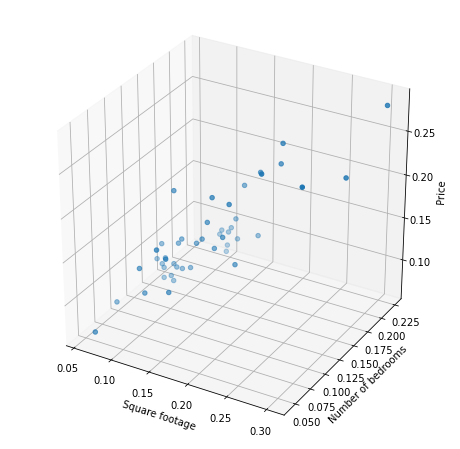

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

xs = X[:, 0]
ys = X[:, 1]
zs = y
ax.scatter(xs, ys, zs)

ax.set_xlabel('Square footage')
ax.set_ylabel('Number of bedrooms')
ax.set_zlabel('Price')

It appears that our data points are distributed closely to a 2D plane, though it can be hard to see on a 3D plot. Let's look at each feature individually vs. the target.

2. Make a plot of the square footage (first column of the `X` matrix) vs. the housing price (`y`).

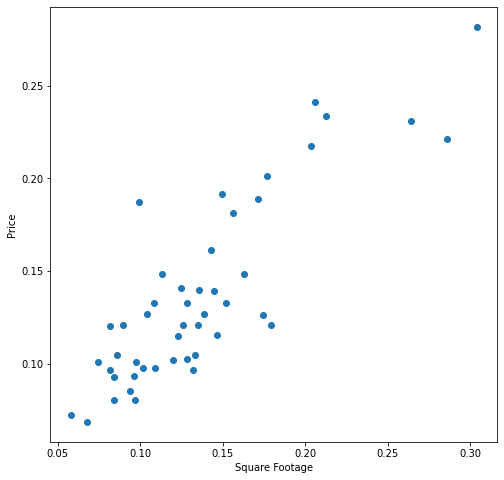

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
x = X[:, 0]
y = y
ax.scatter(x, y)
ax.set_ylabel('Price')
ax.set_xlabel('Square Footage')
plt.show()

3. Make a plot of the number of bedrooms (second column of the `X` matrix) vs. the housing price (`y`).

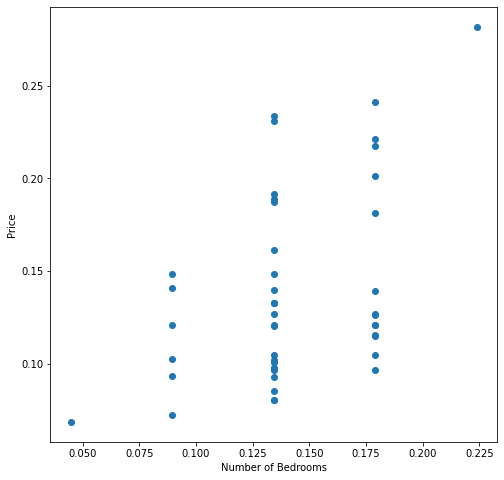

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
x = X[:, 1]
y = y
ax.scatter(x, y)
ax.set_ylabel('Price')
ax.set_xlabel('Number of Bedrooms')
plt.show()

Since the data appears to be in a linear plane in the 3D plot, and in a line on the 2D plots, multivariate linear regression should be a good model.

### Part 4: Gradient Descent Setup

#### Hyperparameters

We will be using gradient descent to find the optimal plane of best fit for the data. Gradient descent is an interative algorithm for finding the solution which minimizes a loss function. We need to supply it with some hyper parameters that will determine how much we modify values at each iteration and how many iterations we allow.

The hyperparameters aren't tuned by the model but will determine how quickly it lands on the optimal solution.

The three most common methods for updating the loss function gradients and learned parameters are: 

1. Batch gradient descent - Each update uses the entire dataset
2. Stochastic gradient descent - The gradients and parameters are updated after every training example
3. Mini-batch gradient descent - Something in between batch and stochastic gradient descent: The model reads in a subset of the full dataset before updating the gradients and parameters. Mini-batch sizes in powers of 2 are preferable.

We supply below the hyperparameters that we'll be using for the different variants of gradient descent.

In [ ]:
# Batch gradient descent
learning_rate = 0.09
max_iteration = 500

In [ ]:
# Stochastic gradient descent
s_learning_rate = 0.06
s_max_iteration = 500

In [ ]:
# Mini-Batch gradient descent
mb_learning_rate = 0.09
mb_max_iteration = 500
batch_size = 16

#### Parameters

1. Initialize the arrays of theta parameters (one for each of the gradient descent methods above) to be an array of zeros. Each value should correspond to a feature (column of `X`) besides the first which will be for the bias term. So the length of each theta array will be one more than the number of features in `X`.

    Hint: Look at the [np.zeros()](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html) function.

In [ ]:
theta = np.zeros((X.shape[1] + 1, 1))
s_theta = np.zeros((X.shape[1] + 1, 1))
mb_theta = np.zeros((X.shape[1] + 1, 1))
mb_theta.shape

(3, 1)

#### Hypothesis

2. Define a function `h` which:

    * Creates a new feature matrix `X1` which has a new first column of all 1's. `X1` should still have all the columns of `X` so should have one more column than `X`.

    * Computes and returns $\hat{Y}$, which is the matrix multiplation of `X1` and `theta` (the array of learned parameters). Pay attention to the shapes of the matrices to do the matrix multiplication in the correct order.

    Hint: Look at the [np.ones()](https://numpy.org/doc/stable/reference/generated/numpy.ones.html), [np.insert()](https://numpy.org/doc/stable/reference/generated/numpy.insert.html), and [np.dot()](https://numpy.org/doc/stable/reference/generated/numpy.dot.html) functions. Note that you'll need to use `axis=1` with the `np.insert()` function.

In [ ]:
def h(theta, X):
    X1 = np.insert(X, 0, np.ones(X.shape[0]), axis=1)
    return np.dot(X1, theta)

#### Loss Function

We'll use the Mean Squared Error (MSE) for our loss function. The MSE is defined as 

$
J = \textrm{MSE} = \frac{1}{m} \sum_{i=1}^m (Y_i - \hat{Y_i})^2,
$

where $i$ is a given training example and $m$ is the number of training examples, i.e. rows in our dataset. Recall from above that $\hat{Y}$ is a function of `theta` and `X` (the matrix multiplication of the two matrices). 

3. Complete the `loss()` function to calculate the return the Mean Squared Error.

    Hint: Look at the [np.sum()](https://numpy.org/doc/stable/reference/generated/numpy.sum.html) and [np.square()](https://numpy.org/doc/stable/reference/generated/numpy.square.html) functions.
    
    Hint: Use the `h()` function defined above to calculate $\hat{Y}$.

In [ ]:
def loss(theta, X, y):
    return np.sum(np.square(y - h(theta, X)))

#### Calculate Gradients

In gradient descent, we use the gradient of the loss function to determine how to adjust the values of theta at each iteration.

Here is the gradient of our loss function:
$
\frac{\partial J}{\partial \theta} = - \frac{1}{m} X^T \cdot (Y - \hat{Y}).
$

For clarity, $m$ is the number of training examples, the superscript $T$ denotes a matrix transposition, and $\cdot$ denotes a matrix inner product (dot product). 

In code, $\frac{\partial J}{\partial \theta}$ is typically denoted `d_theta`.

4. Complete the `gradient()` function below to calculate the gradient of the loss function as defined above.

    Note that the $X$ in the equation above is $X1$, the $X$ matrix with the column of ones added at the beginning.
    
    Hint: Use `.T` or `.transpose` to transpose a numpy array ([transpose](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.T.html)).

In [ ]:
def gradient(theta, X, y):
    X1 = np.insert(X, 0, np.ones(X.shape[0]), axis=1)
    d_theta = -np.average(np.dot(X1.T, (y - h(theta, X))))
    return d_theta

### Part 5: Gradient descent methods

In general, we update our array of parameters $\theta$ (theta) with the formula 

$
\theta := \theta - \alpha \frac{\partial J}{\partial \theta}, 
$

or in code, 

`theta = theta - learning_rate * d_theta`.

Gradient descent will iterate some number of times doing these updates until we minimize the loss function.

#### Batch Gradient Descent

Batch Gradient Descent (often just called Gradient Descent) uses the full dataset to update `d_theta` at each iteration.

1. Complete the `gradient_descent()` function below. Use your `gradient()` function from above to get the value for `d_theta`.

In [ ]:
def gradient_descent(theta, X, y, learning_rate, max_iteration, gap):
    cost = np.zeros(max_iteration)
    for i in range(max_iteration):
        d_theta = gradient(theta, X, y)
        theta = theta - learning_rate * d_theta
        cost[i] = loss(theta, X, y)
        if i % gap == 0:
            print ('iteration : ', i, ' loss : ', loss(theta, X, y)) 
    return theta, cost

#### Mini-Batch Gradient Descent

Mini-Batch Gradient Descent uses a subset of the data of size `batch_size` to update `d_theta`.

2. Complete the `minibath_gradient_descent()` function below. To get the value for `d_theta`, you will call the `gradient()` function like you did above, but this time you pass it a subset of the data (rows from `j` to `j + batch_size - 1`).

In [ ]:
def minibatch_gradient_descent(theta, X, y, learning_rate, max_iteration, batch_size, gap):
    cost = np.zeros(max_iteration)
    for i in range(max_iteration) :
        for j in range(0, X.shape[0], batch_size):
            d_theta = gradient(theta, X[j:j+(batch_size - 1)], y[j:j+(batch_size - 1)])
            theta = theta - learning_rate * d_theta
    cost[i] = loss(theta, X, y)
    if i % gap == 0:
        print ('iteration : ', i, ' loss : ', loss(theta, X, y)) 
    return theta, cost

#### Stochastic Gradient Descent

In Stochastic Gradient Descent, `d_theta` is updated with a single training example. It is equivalent to Mini-Batch Gradient Descent with a batch size of 1.

3. Complete the `stochastic_gradient_descent()` function below. To get the value fo `d_theta`, call the `gradient()` function using just a single row from `X`.

In [ ]:
def stochastic_gradient_descent(theta, X, y, learning_rate, max_iteration, gap):
    cost = np.zeros(max_iteration)
    for i in range(max_iteration) :
        for j in range(X.shape[0]):
            d_theta = gradient(theta, X[j,:].reshape(1, X.shape[1]), y[j,:].reshape(1, 1))
            theta = theta - learning_rate * d_theta
        cost[i] = loss(theta, X, y)
        if i % gap == 0 :
            print ('iteration : ', i, ' loss : ', loss(theta, X, y)) 
    return theta, cost

### Part 6: Train Model

Now that we've implemented all the steps, we're ready to run the three different gradient descent functions.

1. Run the code below and observe the convergence of the loss function.

In [ ]:
theta, cost = gradient_descent(theta, X, y, learning_rate, max_iteration, 100)

iteration :  0  loss :  1.6526627913322107
iteration :  100  loss :  4.6020486343271386e+23
iteration :  200  loss :  1.3547182316398251e+47
iteration :  300  loss :  3.9879228425530755e+70
iteration :  400  loss :  1.173936264141506e+94


In [ ]:
s_theta, s_cost = stochastic_gradient_descent(s_theta, X, y, s_learning_rate, s_max_iteration, 100)

iteration :  0  loss :  0.13392405297404295
iteration :  100  loss :  0.08955017775336262
iteration :  200  loss :  0.08955017775336262
iteration :  300  loss :  0.08955017775336262
iteration :  400  loss :  0.08955017775336262


In [ ]:
mb_theta, mb_cost = minibatch_gradient_descent(mb_theta, X, y, mb_learning_rate, mb_max_iteration, batch_size, 100)

#### Optimal values of Parameters using Trained Model

Let's look at the optimal values found by each version of Gradient Descent.

2. Compare the values for theta found by the three different versions of gradient descent.

In [ ]:
theta

array([[-5.11282042e+57],
       [-5.11282042e+57],
       [-5.11282042e+57]])

In [ ]:
s_theta

array([[0.10702844],
       [0.10702844],
       [0.10702844]])

In [ ]:
mb_theta

array([[0.10581571],
       [0.10581571],
       [0.10581571]])

#### Cost vs Iteration Plots

We see that the final values are different, but let's see how the cost looks between the three versions by plotting the cost vs. number of iterations.

3. Run the code to plot and take note of the convergence of the three versions of Gradient Descent.

Text(0.5, 1.0, 'Error vs. Training Epoch')

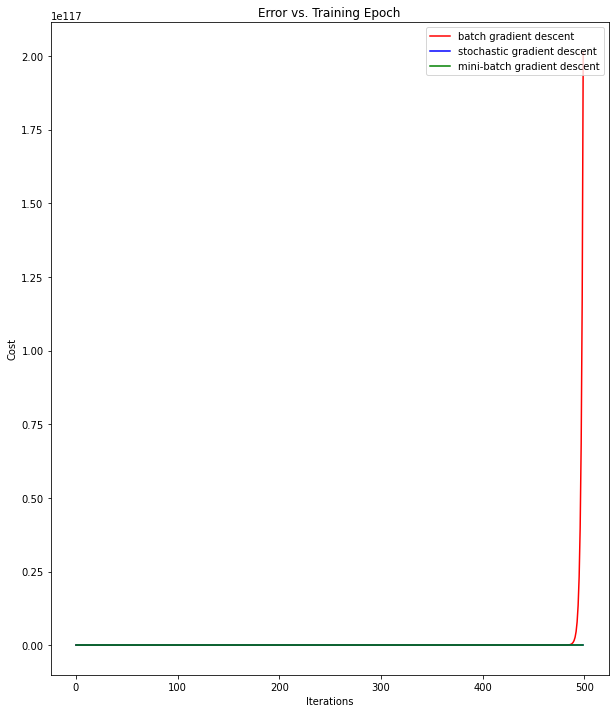

In [ ]:
plt.figure(figsize=(10, 12))
plt.plot(np.arange(max_iteration), cost, 'r')  
plt.plot(np.arange(max_iteration), s_cost, 'b')  
plt.plot(np.arange(max_iteration), mb_cost, 'g')  
plt.legend(loc='upper right', labels=['batch gradient descent', 'stochastic gradient descent', 'mini-batch gradient descent'])
plt.xlabel('Iterations')  
plt.ylabel('Cost')  
plt.title('Error vs. Training Epoch')  

4. Based on the losses and plots after 500 iterations through the dataset, which gradient descent method appears to yield the best predictions for this particular problem?

*[YOUR ANSWER HERE]*

#### Visualize the Data

Our solution corresponds to a plane that splits the data. Let's go back to our original plot of the data and draw on the plane.

5. Run the code below and look at the resulting graph.

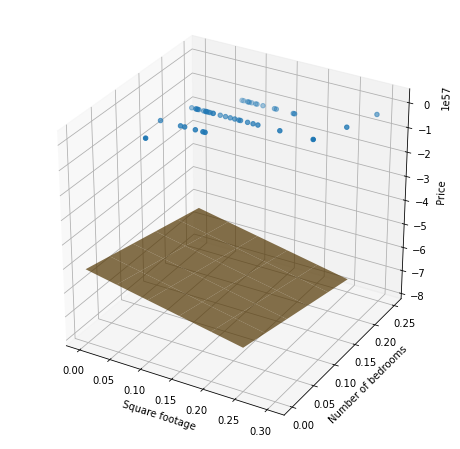

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

xs = X[:, 0]
ys = X[:, 1]
zs = y
ax.scatter(xs, ys, zs)

ax.set_xlabel('Square footage')
ax.set_ylabel('Number of bedrooms')
ax.set_zlabel('Price')

xp, yp = np.meshgrid(np.arange(0, 0.3, 0.05), np.arange(0, 0.3, 0.05))
z = np.array([h(theta, np.array([[i, j]]))[0] for i, j in zip(np.ravel(xp), np.ravel(yp))])
zp = z.reshape(xp.shape)

ax.plot_surface(xp, yp, zp, alpha=0.7, color='orange')

6. Modify the code above to draw the plane for the result of the mini-batch gradient descent.

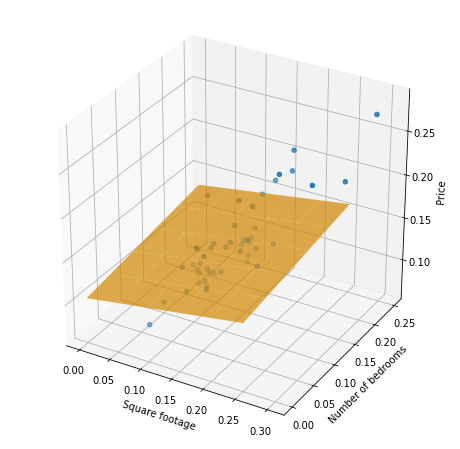

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

xs = X[:, 0]
ys = X[:, 1]
zs = y
ax.scatter(xs, ys, zs)

ax.set_xlabel('Square footage')
ax.set_ylabel('Number of bedrooms')
ax.set_zlabel('Price')

xp, yp = np.meshgrid(np.arange(0, 0.3, 0.05), np.arange(0, 0.3, 0.05))
z = np.array([h(mb_theta, np.array([[i, j]]))[0] for i, j in zip(np.ravel(xp), np.ravel(yp))])
zp = z.reshape(xp.shape)

ax.plot_surface(xp, yp, zp, alpha=0.7, color='orange')

7. Modify the code above to draw the plane for the result of the stochastic gradient descent.

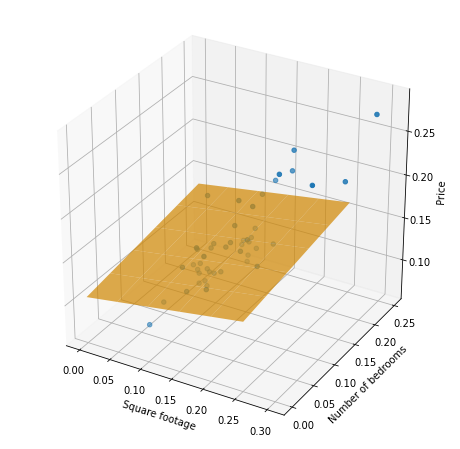

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

xs = X[:, 0]
ys = X[:, 1]
zs = y
ax.scatter(xs, ys, zs)

ax.set_xlabel('Square footage')
ax.set_ylabel('Number of bedrooms')
ax.set_zlabel('Price')

xp, yp = np.meshgrid(np.arange(0, 0.3, 0.05), np.arange(0, 0.3, 0.05))
z = np.array([h(s_theta, np.array([[i, j]]))[0] for i, j in zip(np.ravel(xp), np.ravel(yp))])
zp = z.reshape(xp.shape)

ax.plot_surface(xp, yp, zp, alpha=0.7, color='orange')